In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels
from statsmodels.formula.api import ols
from sklearn.dummy import DummyRegressor
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from sklearn.model_selection import train_test_split
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from sklearn.naive_bayes import MultinomialNB
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

In [2]:
# Initial loading and EDA of data
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='latin-1')
df.drop(index=6, inplace=True)
df.drop_duplicates(inplace=True)
df = df.reset_index(drop=True)
df.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
7,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
8,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
9,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9070 entries, 0 to 9069
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9070 non-null   object
 1   emotion_in_tweet_is_directed_at                     3282 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9070 non-null   object
dtypes: object(3)
memory usage: 212.7+ KB


In [4]:
apple_list = ['iPad', 'Apple', 'iPad or iPhone App', 'Other Apple product or service', 'iPhone']
google_list = ['Google', 'Other Google product or service', 'Android App', 'Android']

df['emotion_in_tweet_is_directed_at'] = ['Apple' if val in apple_list
                                          else val for val in df['emotion_in_tweet_is_directed_at']]

df['emotion_in_tweet_is_directed_at'] = ['Google' if val in google_list
                                          else val for val in df['emotion_in_tweet_is_directed_at']]

df['emotion_in_tweet_is_directed_at'].value_counts()

Apple     2404
Google     878
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [5]:
df['emotion_in_tweet_is_directed_at'] = [val if val == 'Apple' or val == 'Google'
                                          else 'Google' if any(ele.casefold() in df['tweet_text'][ind].casefold() for ele in google_list)
                                          else 'Apple' if any(ele.casefold() in df['tweet_text'][ind].casefold() for ele in apple_list)
                                          else val
                                          for ind, val in df['emotion_in_tweet_is_directed_at'].iteritems()]

df['emotion_in_tweet_is_directed_at'].value_counts()

Apple     5341
Google    2970
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [6]:
df2 = df.dropna(axis = 0)
df2 = df2.rename(columns={"emotion_in_tweet_is_directed_at": "product",\
                   "is_there_an_emotion_directed_at_a_brand_or_product":"emotion"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9070 entries, 0 to 9069
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9070 non-null   object
 1   emotion_in_tweet_is_directed_at                     8311 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9070 non-null   object
dtypes: object(3)
memory usage: 212.7+ KB


In [7]:
df2_label = pd.DataFrame(df2['emotion'].copy())
emotion = df2_label.replace({"emotion": {"Negative emotion" : 1, 
                                "Positive emotion" : 0, 
                                "No emotion toward brand or product" : 2,
                                "I can't tell" : 3}})
df2['emotion'] = emotion
df2['emotion'] = df2['emotion'].astype('int')
df2 = df2[df2['emotion'] != 3]
df2

,tweet_text,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,0
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,0
3,@sxsw I hope this year's festival isn't as cra...,Apple,1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,0
...,...,...,...
9065,Ipad everywhere. #SXSW {link},Apple,0
9066,"Wave, buzz... RT @mention We interrupt your re...",Google,2
9067,"Google's Zeiger, a physician never reported po...",Google,2
9068,Some Verizon iPhone customers complained their...,Apple,2


In [8]:
import re
import string
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)
wspc = lambda x: " ".join(x.split())

df2['tweet_text'] = df2.tweet_text.map(remove_rt).map(rt)
df2['tweet_text'] = df2.tweet_text.str.lower()
df2['tweet_text'] = df2.tweet_text.map(wspc)

df2.head(10)
df2['tweet_text'][9066]

'wave buzz rt we interrupt your regularly scheduled sxsw geek programming with big news link google circles'

In [9]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

def score_matrix_printer(model, X_train, y_train, X_test, y_test):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    avg = 'macro'
    
    ascore_train = accuracy_score(y_train, train_pred)
    pscore_train = precision_score(y_train, train_pred, average=avg)
    rscore_train = recall_score(y_train, train_pred, average=avg)
    
    ascore_test = accuracy_score(y_test, test_pred)
    pscore_test = precision_score(y_test, test_pred, average=avg)
    rscore_test = recall_score(y_test, test_pred, average=avg)
    
    conf_mat = plot_confusion_matrix(model, X_test, y_test)
    
    print(f"""
    Train Accuracy: {ascore_train}
    Train Precision: {pscore_train}
    Train Recall: {rscore_train}
    ------------------------------
    Test Accuracy: {ascore_test}
    Test Precision: {pscore_test}
    Test Recall: {rscore_test}
    """)

In [10]:
def preprocess_text(text):
    additional  = ['rt','rts','retweet']
    pattern = '\s+'
    
    sw = set().union(stopwords.words('english'), additional)
    tokenizer = RegexpTokenizer(pattern, gaps = True)
    stemmer = SnowballStemmer(language = 'english')
#     stemmer = PorterStemmer()
    
    token = tokenizer.tokenize(text)
    
    final = [stemmer.stem(word) for word in token if word not in sw]
    
    return " ".join(final)

In [11]:
def ensemble_result_printer(model, X_train, y_train, X_test, y_test):
    
    scores = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
    unique, counts = np.unique(model.predict(X_test), return_counts=True)
    result = np.column_stack((unique, counts))
    Pos = "{:.2f}".format((result[0][1] / sum(counts)) * 100)
    Neg = "{:.2f}".format((result[1][1] / sum(counts)) * 100)
    Neut = "{:.2f}".format((result[2][1] / sum(counts)) * 100)

    print(f"""
Ensemble CV Score: {np.median(scores)}
Final Test Accuracy: {accuracy_score(y_test, model.predict(X_test))}
Final Test Precision: {precision_score(y_test, model.predict(X_test), average='macro')}
Final Test Recall: {recall_score(y_test, model.predict(X_test), average='macro')}
----------------------------------------------------
{result}
Positive : {Pos}%
Negative : {Neg}%
Neutral : {Neut}%
""")
    plot_confusion_matrix(avg, g_X_test, g_y_test);

In [12]:
df2['tweet_text'] = df2["tweet_text"].map(lambda x : preprocess_text(x))
df2

,tweet_text,product,emotion
0,3g iphon 3 hrs tweet rise austin dead need upg...,Apple,1
1,know awesom ipad iphon app like appreci design...,Apple,0
2,wait ipad 2 also sale sxsw,Apple,0
3,hope year festiv crashi year iphon app sxsw,Apple,1
4,great stuff fri sxsw marissa mayer googl tim r...,Google,0
...,...,...,...
9065,ipad everywher sxsw link,Apple,0
9066,wave buzz interrupt regular schedul sxsw geek ...,Google,2
9067,googl zeiger physician never report potenti ae...,Google,2
9068,verizon iphon custom complain time fell back h...,Apple,2


In [13]:
apple = df2.loc[df2['product'] == 'Apple']
apple

,tweet_text,product,emotion
0,3g iphon 3 hrs tweet rise austin dead need upg...,Apple,1
1,know awesom ipad iphon app like appreci design...,Apple,0
2,wait ipad 2 also sale sxsw,Apple,0
3,hope year festiv crashi year iphon app sxsw,Apple,1
5,new ipad app speechtherapi communic showcas sx...,Apple,2
...,...,...,...
9056,quot papyrus sort like ipad quot nice lol sxsw...,Apple,0
9059,appl guy scream run line open shop austin sxsw...,Apple,2
9062,alway use camera iphon b c imag stabil mode su...,Apple,0
9065,ipad everywher sxsw link,Apple,0


In [14]:
google = df2.loc[df2['product'] == 'Google']
google

,tweet_text,product,emotion
4,great stuff fri sxsw marissa mayer googl tim r...,Google,0
6,sxsw start ctia around corner googleio hop ski...,Google,0
9,excit meet sxsw show sprint galaxi still run a...,Google,0
10,find amp start impromptu parti sxsw wait til a...,Google,0
11,foursquar up game time sxsw still prefer far b...,Google,0
...,...,...,...
9063,googl say want give lightn talk h4cker audienc...,Google,2
9064,yup third app yet android suggest sxsw cc,Google,2
9066,wave buzz interrupt regular schedul sxsw geek ...,Google,2
9067,googl zeiger physician never report potenti ae...,Google,2


In [15]:
X = df2['tweet_text']
y = df2['emotion']

In [16]:
a_X = apple['tweet_text']
a_y = apple['emotion']

g_X = google['tweet_text']
g_y = google['emotion']

sample_document = df['tweet_text'].iloc[1].body

sample_doc = tokenizer.tokenize(sample_document)
sample_doc = [token.lower() for token in sample_doc]
sw = stopwords.words('english')
sample_doc = [token for token in sample_doc if token not in sw]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [18]:
a_X_train, a_X_test, a_y_train, a_y_test = train_test_split(a_X, a_y, random_state=42)

g_X_train, g_X_test, g_y_train, g_y_test = train_test_split(g_X, g_y, random_state=42)

In [19]:
cv = CountVectorizer()
# Since we're transforming training set, we have to transform test set as well
X_train_vec = cv.fit_transform(X_train)
X_test_vec = cv.transform(X_test)


X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(cv.vocabulary_)
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec)
X_test_vec.columns = sorted(cv.vocabulary_)
X_test_vec.set_index(y_test.index, inplace=True)
X_train_vec

,00,000,00am,00pm,01am,02,03,08,10,100,...,zip,zite,zms,zombi,zomg,zone,zoom,zuckerberg,zynga,zzzs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6116,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6117,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6118,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
X_train_vec.sum().sort_values(ascending=False).head()

sxsw     6500
link     2697
googl    1957
ipad     1930
appl     1742
dtype: int64

In [21]:
# Initialize baseline MultinomialBayes for NLP
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)

MultinomialNB()

Training Accuracy: 0.8
Training Recall: 0.6883996700004489
Test Accuracy: 0.6467417932386085
Test Recall: 0.5023168509224286


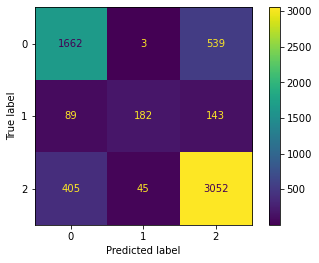

In [22]:
# Creating initial predictions
y_preds = mnb.predict(X_train_vec)
y_test_pred = mnb.predict(X_test_vec)
print("Training Accuracy:", accuracy_score(y_train, y_preds))
print("Training Recall:", recall_score(y_train, y_preds, average = 'macro'))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Recall:", recall_score(y_test, y_test_pred, average = 'macro'))
cm = confusion_matrix(y_train, y_preds)
cmdisplay = ConfusionMatrixDisplay(cm)
cmdisplay.plot();

In [23]:
# score_matrix_printer(mnb, X_train, y_train, X_test, y_test)


    Train Accuracy: 0.7838235294117647
    Train Precision: 0.7027811941799588
    Train Recall: 0.7592961215912996
    ------------------------------
    Test Accuracy: 0.6291033806957373
    Test Precision: 0.5416153087576664
    Test Recall: 0.5659851109164965
    


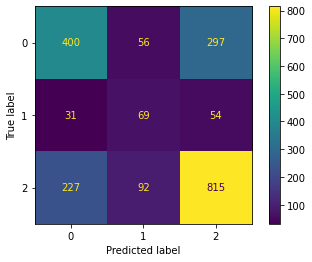

In [24]:
# Pipeline model for Multinomial Bayes + SMOTE
mnb_cv = imbpipeline(steps=[
    ('vectorizer', CountVectorizer()),
    ('SMOTE', SMOTE(sampling_strategy = 'minority', random_state = 42)),
    ('mnb', MultinomialNB())
])

mnb_cv.fit(X_train, y_train)
score_matrix_printer(mnb_cv, X_train, y_train, X_test, y_test)


    Train Accuracy: 0.7638888888888888
    Train Precision: 0.6954157101408565
    Train Recall: 0.8230162253295453
    ------------------------------
    Test Accuracy: 0.5982361587457129
    Test Precision: 0.5401633603162668
    Test Recall: 0.6213907663664193
    


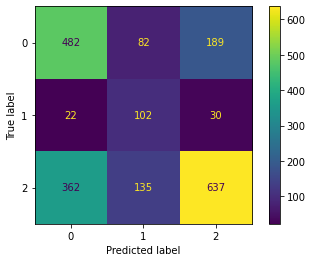

In [25]:
# Pipeline model to test if TfidfVectorizer is better than CountVectorizer
mnb_tfidf = imbpipeline(steps=[
    ('vectorizer', TfidfVectorizer(lowercase = False)),
    ('SMOTE', SMOTE(random_state = 42)),
    ('mnb', MultinomialNB())
])

mnb_tfidf.fit(X_train, y_train)
score_matrix_printer(mnb_tfidf, X_train, y_train, X_test, y_test)


    Train Accuracy: 0.6826797385620915
    Train Precision: 0.6143997327270285
    Train Recall: 0.7425456401552982
    ------------------------------
    Test Accuracy: 0.5752082312591866
    Test Precision: 0.514573459600121
    Test Recall: 0.586427205506444
    


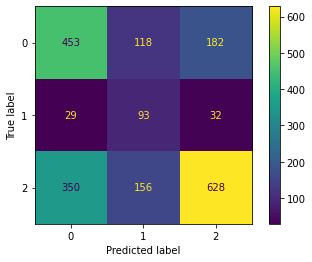

In [26]:
# Pipeline model to test if TfidfVectorizer is better than CountVectorizer
mnb_tfidf_mf = imbpipeline(steps=[
    ('vectorizer', TfidfVectorizer(lowercase = False, max_features=1500)),
    ('SMOTE', SMOTE(random_state = 42)),
    ('mnb', MultinomialNB())
])

mnb_tfidf_mf.fit(X_train, y_train)
score_matrix_printer(mnb_tfidf_mf, X_train, y_train, X_test, y_test)

In [27]:
from sklearn.ensemble import RandomForestClassifier


    Train Accuracy: 0.9535947712418301
    Train Precision: 0.9470441664341451
    Train Recall: 0.9538167087432935
    ------------------------------
    Test Accuracy: 0.5835374816266536
    Test Precision: 0.5015104928578232
    Test Recall: 0.5331166382516538
    


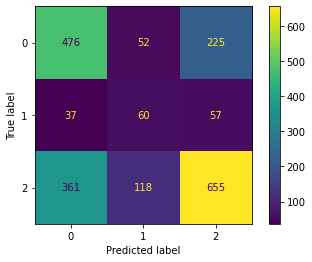

In [28]:
rf_optimal_cv = imbpipeline(steps=[
    ('vectorizer', CountVectorizer()),
    ('smote', SMOTE(random_state = 42)),
    ('rf', RandomForestClassifier(random_state = 42))

])

rf_optimal_cv.fit(X_train, y_train)
score_matrix_printer(rf_optimal_cv, X_train, y_train, X_test, y_test)


    Train Accuracy: 0.9549019607843138
    Train Precision: 0.9539085995908437
    Train Recall: 0.9548955145599923
    ------------------------------
    Test Accuracy: 0.6452719255267026
    Test Precision: 0.6281029920143858
    Test Recall: 0.5237158362435034
    


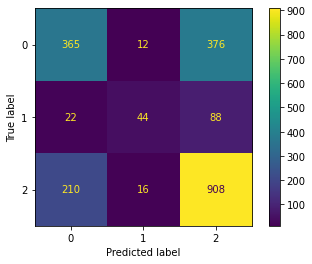

In [29]:
rf_model_max = imbpipeline(steps=[
    ('vectorizer', TfidfVectorizer(lowercase = False, max_features=1500)),
    ('smote', SMOTE(random_state = 42)),
    ('rf', RandomForestClassifier(random_state = 42))

])

rf_model_max.fit(X_train, y_train)
score_matrix_printer(rf_model_max, X_train, y_train, X_test, y_test)

In [30]:
# #Code block has been commented out as it takes 10+ minutes to run.
# from sklearn.model_selection import GridSearchCV

# X_train_grid, X_test_grid, y_train_grid, y_test_grid = train_test_split(text_series, y, random_state=42)

# rf_basic_cv = imbpipeline(steps=[
#     ('preprocess', TfidfVectorizer(lowercase = False)),
#     ('SMOTE', SMOTE(sampling_strategy = 'minority', random_state = 42)),
#     ('rf', RandomForestClassifier(random_state=42))
# ])


# param_grid = {
#     "preprocess__max_features":[500, 1000, 1500],
#     "rf__n_estimators":[30, 100, 150, 200],
#     "rf__criterion":['gini', 'entropy'], 
#     "rf__max_depth":[1, 10, 25, 50],
#     "rf__min_samples_split":range(1, 10),
#     "rf__min_samples_leaf":range(1, 10)
# }            


# grid = GridSearchCV(rf_basic_cv, param_grid, cv = 5, n_jobs = -1, verbose = 1)
# grid.fit(X_train_grid, y_train_grid)   

In [31]:
# print('Best score and parameter combination = ')

# print(grid.best_score_)    
# print(grid.best_params_)      


    Train Accuracy: 0.9184640522875817
    Train Precision: 0.9346355694598899
    Train Recall: 0.8974041076188589
    ------------------------------
    Test Accuracy: 0.6398824105830475
    Test Precision: 0.5940866844976433
    Test Recall: 0.51597479463792
    


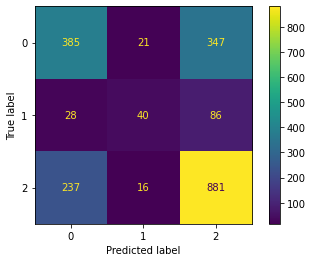

In [32]:
rf_optimal_cv = imbpipeline(steps=[
    ('vectorizer', TfidfVectorizer(lowercase = False, max_features=1500)),
    ('smote', SMOTE(random_state = 42)),
    ('rf', RandomForestClassifier(criterion = 'gini', n_estimators = 150,  max_depth = 50, 
                                  min_samples_leaf = 1, min_samples_split = 5, random_state = 42))

])

rf_optimal_cv.fit(X_train, y_train)
score_matrix_printer(rf_optimal_cv, X_train, y_train, X_test, y_test)


Ensemble CV Score: 0.6413398692810458
Final Test Accuracy: 0.6398824105830475
Final Test Precision: 0.5940866844976433
Final Test Recall: 0.51597479463792
----------------------------------------------------
[[   0  650]
 [   1   77]
 [   2 1314]]
Positive : 31.85%
Negative : 3.77%
Neutral : 64.38%



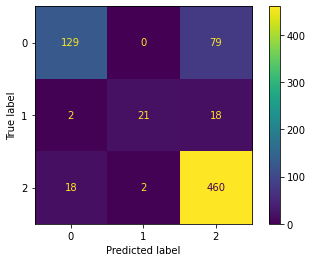

In [35]:
from sklearn.ensemble import VotingClassifier
avg = VotingClassifier(estimators=[ ('rf', rf_optimal_cv),
                                    ('mb', mnb_tfidf_mf)],
                                    weights = [0.75, 0.25])

avg.fit(X_train, y_train)

ensemble_result_printer(avg, X_train, y_train, X_test, y_test)

In [36]:
a_X_train, a_X_test, a_y_train, a_y_test = train_test_split(a_X, a_y, random_state=42)

g_X_train, g_X_test, g_y_train, g_y_test = train_test_split(g_X, g_y, random_state=42)


Ensemble CV Score: 0.6175349428208387
Final Test Accuracy: 0.6295731707317073
Final Test Precision: 0.5948644708046777
Final Test Recall: 0.5356985016751061
----------------------------------------------------
[[  0 458]
 [  1  69]
 [  2 785]]
Positive : 34.91%
Negative : 5.26%
Neutral : 59.83%



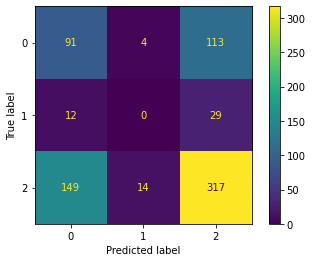

In [37]:
avg = VotingClassifier(estimators=[ ('rf', rf_optimal_cv),
                                    ('mb', mnb_tfidf_mf)],
                                    weights = [0.75, 0.25])

avg.fit(a_X_train, a_y_train)

#This block may take a minute because it is run on the ensemble
ensemble_result_printer(avg, a_X_train, a_y_train, a_X_test, a_y_test)


Ensemble CV Score: 0.7276887871853547
Final Test Accuracy: 0.6899862825788752
Final Test Precision: 0.602046783625731
Final Test Recall: 0.4935871377944549
----------------------------------------------------
[[  0 140]
 [  1  19]
 [  2 570]]
Positive : 19.20%
Negative : 2.61%
Neutral : 78.19%



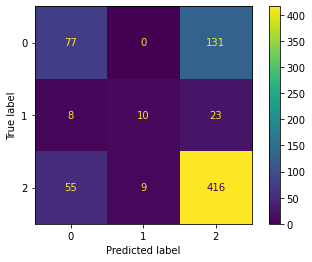

In [38]:
avg = VotingClassifier(estimators=[ ('rf', rf_optimal_cv),
                                    ('mb', mnb_tfidf_mf)],
                                    weights = [0.75, 0.25])

avg.fit(g_X_train, g_y_train)

#This block may take a minute because it is run on the ensemble
ensemble_result_printer(avg, g_X_train, g_y_train, g_X_test, g_y_test)